In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
import random

# Folder containing the .csv files
folder_path = "./time_sets_standardized"

# Map tile size in nautical miles
tile_width_nm = 2.5
tile_height_nm = 2.5

# Conversion from nautical miles to degrees (approximate, depends on latitude)
nm_to_deg = 1 / 60

# Initialize a dictionary to count navigational statuses
nav_status_counts = {}

# Function to calculate bounding box
def calculate_bounding_box(center_lat, center_lon, width_nm, height_nm):
    lat_delta = height_nm * nm_to_deg
    lon_delta = width_nm * nm_to_deg / np.cos(np.radians(center_lat))
    return (center_lat - lat_delta, center_lat + lat_delta,
            center_lon - lon_delta, center_lon + lon_delta)

# Function to plot vessel movements on a map tile
def plot_map(data, file_name, bbox):
    plt.figure(figsize=(8, 8))
    plt.plot(data['Longitude'], data['Latitude'], marker='o', markersize=4, label='Vessel Movement')
    plt.xlim([bbox[2], bbox[3]])  # Set longitude bounds
    plt.ylim([bbox[0], bbox[1]])  # Set latitude bounds
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Vessel Movement: {file_name}")
    plt.legend()
    plt.grid()
    plt.savefig(f"map_tiles/{file_name}.png")
    plt.close()

# Create output folder for map tiles
os.makedirs("map_tiles", exist_ok=True)

# Get the list of CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

# Select a random 10% of the files (rounding up if necessary)
random_files = random.sample(csv_files, max(1, int(len(csv_files) * 0.1)))

# Process the selected files
for file in random_files:
    file_path = os.path.join(folder_path, file)
    
    # Load CSV file
    data = pd.read_csv(file_path)
    
    # Ensure 'Navigational status' has a single unique value
    unique_status = data['Navigational status'].unique()
    if len(unique_status) == 1:
        status = unique_status[0]
        nav_status_counts[status] = nav_status_counts.get(status, 0) + 1
        
        # Calculate the bounding box for the map tile
        center_lat = data['Latitude'].mean()
        center_lon = data['Longitude'].mean()
        bbox = calculate_bounding_box(center_lat, center_lon, tile_width_nm, tile_height_nm)
        
        # Plot the map tile
        plot_map(data, file.replace(".csv", ""), bbox)

# Display the counts of navigational statuses
print("Counts of Navigational Statuses:")
for status, count in nav_status_counts.items():
    print(f"Status {status}: {count} files")


Counts of Navigational Statuses:
Status Under way using engine: 74 files
Status Engaged in fishing: 12 files
Status At anchor: 21 files
Status Moored: 1 files
Status Constrained by her draught: 1 files


In [1]:
import os
import pandas as pd

# Folder containing the CSV files
folder_path = "./filtered_area"

# Initialize a set to store unique navigational statuses
unique_statuses = set()

# Loop through all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
                    
        # Read the CSV file, handling the '# Timestamp' column
        df = pd.read_csv(file_path, skipinitialspace=True)
        df.rename(columns=lambda x: x.strip(), inplace=True)
                                                    
        # Add unique Navigational Status values to the set
        if "Navigational status" in df.columns:
               unique_statuses.update(df["Navigational status"].dropna().unique())

# Display one example of each unique Navigational Status
print("Unique Navigational Status entries found in the data:")
for status in unique_statuses:
       print(f"- {status}")


Unique Navigational Status entries found in the data:
- Constrained by her draught
- Under way sailing
- At anchor
- Moored
- Under way using engine
- Engaged in fishing
- Restricted maneuverability


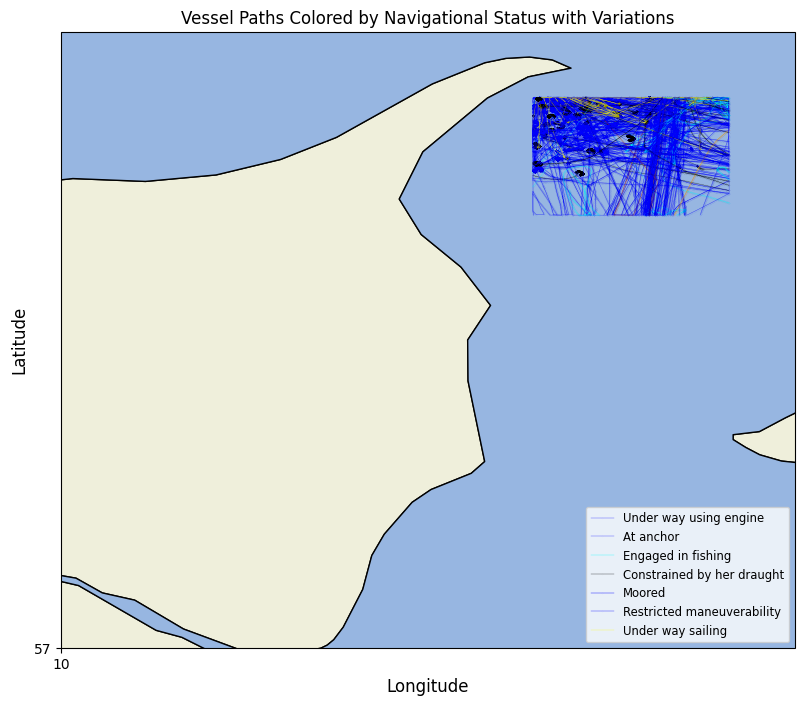

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import random

# Folder containing the CSV files
folder_path = "./filtered_area"

# Initialize lists to store latitude, longitude, and navigational status data
all_latitudes = []
all_longitudes = []
all_statuses = []

# Loop through all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file, handling the '# Timestamp' column
        df = pd.read_csv(file_path, skipinitialspace=True)
        df.rename(columns=lambda x: x.strip(), inplace=True)
        
        # Extract Latitude, Longitude, and Navigational Status columns
        if "Latitude" in df.columns and "Longitude" in df.columns and "Navigational status" in df.columns:
            all_latitudes.extend(df["Latitude"].dropna())
            all_longitudes.extend(df["Longitude"].dropna())
            all_statuses.extend(df["Navigational status"].dropna())

# Ensure we have data to plot
if not all_latitudes or not all_longitudes or not all_statuses:
    print("No valid latitude/longitude/status data found in the CSV files.")
    exit()

# Determine map bounds with 60 nautical miles extension (1 nautical mile = 1/60 degree)
nautical_mile_in_degrees = 1 / 60
extend_by = 5 * nautical_mile_in_degrees
min_lat, max_lat = min(all_latitudes) - extend_by, max(all_latitudes) + extend_by
min_lon, max_lon = min(all_longitudes) - extend_by, max(all_longitudes) + extend_by

# Create a map with Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

# Add latitude and longitude labels
ax.set_xticks(range(int(min_lon), int(max_lon) + 1, max(1, int((max_lon - min_lon) / 5))), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(min_lat), int(max_lat) + 1, max(1, int((max_lat - min_lat) / 5))), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=10)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Define base colors for different Navigational Statuses
status_colors = {
    "Under way using engine": "blue",
    "Moored": "brown",
    "Restricted maneuverability": "orange",
    "Engaged in fishing": "cyan",
    "Under way sailing": "yellow"
}

# Generate color variations for each vessel
vessel_colors = {}

# Plot vessel paths colored by Navigational Status with variations
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path, skipinitialspace=True)
        df.rename(columns=lambda x: x.strip(), inplace=True)
        
        # Assign unique color variations for each vessel
        mmsi = df["MMSI"].iloc[0] if "MMSI" in df.columns else file_name
        if mmsi not in vessel_colors:
            base_color = status_colors.get(df["Navigational status"].iloc[0], "black")
            vessel_colors[mmsi] = mcolors.to_rgba(base_color, alpha=random.uniform(0.6, 1.0))
        
        # Plot the vessel path
        if "Latitude" in df.columns and "Longitude" in df.columns and "Navigational status" in df.columns:
            for status, group in df.groupby("Navigational status"):
                latitudes = group["Latitude"].dropna()
                longitudes = group["Longitude"].dropna()
                color = vessel_colors[mmsi]  # Use vessel-specific color
                ax.plot(longitudes, latitudes, marker='o', linestyle='-', linewidth=0.3, markersize=0.01, color=color, transform=ccrs.PlateCarree(), label=status)

# Add legend and title
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize='small')
plt.title("Vessel Paths Colored by Navigational Status with Variations")

# Show the map
plt.show()
